# This is the final pipeline program for ET star ID process

# It uses an initial set of stars that are within (RHM+RT)/2
# Only GCs w/ at least 20 stars in the range above are chosen

# For dim reduction, it has a set seed of 2023 for both tSNE and UMAP

# For control DBSCAN, it uses N/sigma^2 and has a requirement of at least 15 controls

# For field DBSCAN, it uses N(ctrl) / sigma(cluster)^2 and has a requirement of capturing all of the control stars

# This also adds the diff abundance trios

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [4]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

# save and load
import pickle

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [5]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt2 = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')


### drop all NaN kinematic and chemistry values
apogee_nofilt = apogee_nofilt2.dropna(subset=['FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
apogee_nofilt = apogee_nofilt.reset_index(drop=True)
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

#### Selecting initial star field

In [7]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    fov_new = 5 * rt_deg
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov_new and i <= ra + fov_new and df['DEC'].values[count] >= dec - fov_new and df['DEC'].values[count] <= dec + fov_new:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a ' + str(fov_new) + 'x' + str(fov_new) + ' fov of the GC')
    
    return stars
            

#### Separating list of stars into lists by parameter

In [8]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [9]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [10]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [12]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [14]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [35]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [36]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

#### Master filter function

In [37]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 13)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [38]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trhmrt2: {:.2f}\trt: {:.2f}'.format(rhm_deg, (rhm_deg + rt_deg) / 2, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    ### TEST: rhm stars
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + " and {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_N_ctrl_sigma_cluster/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return indices_control

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [39]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pretsne_array = []
    params_arr = []
    
    for key in param_dict:
        pretsne_array.append(data_filter[param_dict[key]])
        params_arr.append(key)
    
    pretsne_array = np.array(pretsne_array)
    
    standardized = []
    
    for i in pretsne_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    return standardized

#### tSNE function

In [40]:
def master_tSNE(data_filter, param_dict, indices_control, name, num_total_stars):
    standardized_array = standardize_data(data_filter, param_dict)
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)
    
    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2, perplexity=50, random_state=2023)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    tsne_dimX = tsne_2d[:, 0]
    tsne_dimY = tsne_2d[:, 1]

    # Get t-SNE outputs for control group:
    tsne_dimX_control = tsne_dimX[indices_control]
    tsne_dimY_control = tsne_dimY[indices_control]
    
    '''fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(tsne_dimX, tsne_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control , tsne_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=12, loc=1)
    plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/tsne.png')
    plt.close('all')'''
        
    return [tsne_dimX, tsne_dimY, tsne_dimX_control, tsne_dimY_control]

#### UMAP function

In [41]:
def master_UMAP(data_filter, param_dict, indices_control, name, num_total_stars):
    standardize = standardize_data(data_filter, param_dict)
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)
    
    # Run umap on the transposed array:
    reducer = umap.UMAP(n_neighbors=50, random_state=2023)
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get umap outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get umap outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    '''fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=12)
    plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/umap.png')
    plt.close('all')'''
    
    return [umap_dimX, umap_dimY, umap_dimX_control, umap_dimY_control]

#### Choosing which parameters to use for tSNE and UMAP

In [42]:
def ask_input_param(param):
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [43]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

#### Taking in datasheet and name and automatically getting the parameters

In [44]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [45]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

### Master function (automatic version)

In [59]:
def master_func_auto(GC_name, master_param_dict, fov, db, dataset, params):
    print('\nProcessing:', GC_name)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg, rt_deg, GC_name)
        
        # no control stars
        #print(GC_indices_control)
        if GC_indices_control[0] is None:
            #print("This shit got no control stars\n")
            return [None, None, None, None, None, None, None, None]
        
        else:
            # choosing parameters
            param_dict = master_param_dict
                
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control]

#### Global GC params

In [60]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_chem_list = ['CI_FE', 'N_FE',
              'O_FE', 'MG_FE', 'AL_FE', 'SI_FE',
              'P_FE', 'S_FE', 'K_FE', 'CA_FE',
              'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE',
              'MN_FE', 'CO_FE', 'NI_FE']

all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

# dim reduction kin

In [61]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [64]:
GC_total_dict = {} # dictionary for each chem iteration, with each key holding a dictionary for each GC

In [63]:
start = time.time()

for n, c in enumerate(tqdm(all_chem_list)):
    print('\nProcessing chem: ', c)
    chosen_params = ['FE_H', 'C_FE', c, 'RV', 'PMRA', 'PMDEC']
    
    new_param_dict = {}
    for key in all_param_dict:
        if key in chosen_params:
            new_param_dict[key] = all_param_dict[key]
    
    GC_stars_dict = {}
    for count, i in enumerate(tqdm(GC_name_list)):
        GC_stars_dict[i] = master_func_auto(i, new_param_dict, fov, GC_db, apogee_nofilt, param_list)

    GC_total_dict[GC_name_list[n]] = GC_stars_dict
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing chem:  CI_FE



Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

The final amount of stars in our sample is: 977
rhm: 0.08	rhmrt2: 0.84	rt: 1.61
There are 0 stars within rhm and 137 stars within (rhm+rt)/2 and 185 stars within the rt
Directory NGC_104 already exists
Done!


Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

The final amount of stars in our sample is: 193
rhm: 0.05	rhmrt2: 0.33	rt: 0.60
There are 12 stars within rhm and 49 stars within (rhm+rt)/2 and 84 stars within the rt
Directory NGC_288 already exists
Done!


Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

The final amount of stars in our sample is: 743
rhm: 0.02	rhmrt2: 0.31	rt: 0.60
There are 0 stars within rhm and 38 stars within (rhm+rt)/2 and 61 stars within the rt
Directory NGC_362 already exists
Done!


Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

The final amount of stars

Done!


Processing: NGC_6715
1445 stars in a 3.088140337132516x3.088140337132516 fov of the GC

The final amount of stars in our sample is: 1445
rhm: 0.01	rhmrt2: 0.31	rt: 0.62
There are 0 stars within rhm and 69 stars within (rhm+rt)/2 and 160 stars within the rt
Directory NGC_6715 already exists
Done!


Processing: NGC_6752
230 stars in a 4.688239696402624x4.688239696402624 fov of the GC

The final amount of stars in our sample is: 230
rhm: 0.07	rhmrt2: 0.51	rt: 0.94
There are 6 stars within rhm and 129 stars within (rhm+rt)/2 and 181 stars within the rt
Directory NGC_6752 already exists
Done!


Processing: NGC_6809
337 stars in a 2.758679736454458x2.758679736454458 fov of the GC

The final amount of stars in our sample is: 337
rhm: 0.07	rhmrt2: 0.31	rt: 0.55
There are 31 stars within rhm and 104 stars within (rhm+rt)/2 and 162 stars within the rt
Directory NGC_6809 already exists
Done!


Processing: NGC_6838
1602 stars in a 3.091703467166187x3.091703467166187 fov of the GC

The fina


Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

The final amount of stars in our sample is: 977
rhm: 0.08	rhmrt2: 0.84	rt: 1.61
There are 0 stars within rhm and 137 stars within (rhm+rt)/2 and 185 stars within the rt
Directory NGC_104 already exists
Done!


Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

The final amount of stars in our sample is: 193
rhm: 0.05	rhmrt2: 0.33	rt: 0.60
There are 12 stars within rhm and 49 stars within (rhm+rt)/2 and 84 stars within the rt
Directory NGC_288 already exists
Done!


Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

The final amount of stars in our sample is: 743
rhm: 0.02	rhmrt2: 0.31	rt: 0.60
There are 0 stars within rhm and 38 stars within (rhm+rt)/2 and 61 stars within the rt
Directory NGC_362 already exists
Done!


Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

The final amount of stars

MemoryError: Unable to allocate 1.15 MiB for an array with shape (150352,) and data type int64

In [28]:
### saving dim reduction w/ kin results

with open('saved_runs_5_RT_Rosie/GC_total_dict_kin.pkl', 'wb') as f:
    pickle.dump(GC_total_dict, f)

In [21]:
### reading dim reduction w/ kin results

with open('saved_runs_5_RT_Rosie/GC_total_dict_kin.pkl', 'rb') as f:
    GC_total_dict = pickle.load(f)

In [22]:
control_stars_list_total = [] # list of control stars for each iteration (17, 34, n_ctrl)
total_stars_list_total = [] # list of total stars for each iteration (17, 34, n_ctrl)

for k in GC_total_dict:
    GC_stars_dict = GC_total_dict[k]
    
    control_stars_list = [] # list of # of control stars
    total_stars_list = [] # list of # of total stars

    sum = 0
    for key in GC_stars_dict: # going through and cutting out the ones that have None (i.e. no control stars)
        if GC_stars_dict[key][2] is None: # if there is no controls, we set the number of control and all stars to 0
            control_stars_list.append(0)
            total_stars_list.append(0)
        else:
            sum += 1
            control_stars_list.append(len(GC_stars_dict[key][2]))
            total_stars_list.append(len(GC_stars_dict[key][0]))
            
    control_stars_list_total.append(control_stars_list)
    total_stars_list_total.append(total_stars_list)

In [23]:
new_control_stars_list_total = [] # control stars we want to keep for each iteration (17, 34, n_ctrl)
new_total_stars_list_total = [] # total stars we want to keep for each iteration (17, 34, n_total)
new_stars_index_list_total = [] # indices of total stars for each iteration (17, 34, n_total)

for n in range(len(control_stars_list_total)):
    control_stars_list = control_stars_list_total[n]
    total_stars_list = total_stars_list_total[n]
    
    new_control_stars_list = [] # control stars we want to keep
    new_total_stars_list = [] # total stars we want to keep
    new_stars_index_list = [] # indices of total stars

    for i in range(len(control_stars_list))
        if control_stars_list[i] != 0: # if the number of the control stars were not 0, keep the GC
            new_control_stars_list.append(control_stars_list[i])
            new_total_stars_list.append(total_stars_list[i])
            new_stars_index_list.append(i)
            
    new_control_stars_list_total.append(new_control_stars_list)
    new_total_stars_list_total.append(new_total_stars_list)
    new_stars_index_list_total.append(new_stars_index_list)

In [24]:
GC_name_arr = np.empty(len(new_stars_index_list_total[0]), dtype=np.ndarray) # names of the final GCs # (34)

# tsne x,y coords
tsne_control_X_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray) # (17, 34, n_ctrltsne)
tsne_control_Y_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray)
tsne_all_X_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray) # (17, 34, n_total)
tsne_all_Y_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray)

# umap x,y coords
umap_control_X_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray) # (17, 34, n_ctrlumap)
umap_control_Y_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray)
umap_all_X_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray) # (17, 34, n_total)
umap_all_Y_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray)

# control star indices
control_indices_rad_total = np.empty(len(new_stars_index_list_total), dtype=np.ndarray) # (17, 34, n_ctrlrads)

for n, k in enumerate(GC_total_dict):
    GC_stars_dict = GC_total_dict[k]
    new_stars_index_list = new_stars_index_list_total[i]

    # tsne x,y coords
    tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

    # umap x,y coords
    umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
    umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

    # control star indices
    control_indices_rad = np.empty(len(new_stars_index_list), dtype=np.ndarray)

    # going through the GCs that had control stars and breaking up the dictionary into the star lists above
    for i in range(len(new_stars_index_list)):
        ind = new_stars_index_list[i]
        GC_name_arr[i] = GC_name_list[ind]

        tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
        tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
        tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
        tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]

        umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][6]
        umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][7]
        umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
        umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]

        control_indices_rad[i] = GC_stars_dict[GC_name_arr[i]][8]
        
    tsne_control_X_total[i] = tsne_control_X
    tsne_control_Y_total[i] = tsne_control_Y
    tsne_all_X_total[i] = tsne_all_X
    tsne_all_Y_total[i] = tsne_all_Y
    
    umap_control_X_total[i] = umap_control_X
    umap_control_Y_total[i] = umap_control_Y
    umap_all_X_total[i] = umap_all_X
    umap_all_Y_total[i] = umap_all_Y
    
    control_indices_rad_total[i] = control_indices_rad

# DBSCAN control stars

In [9]:
def plot_ML(name, pack, ML, abundances):
    ### function that plots the tsne and umap of the GC again
    ### tsne = [ctrlX, ctrlY, allX, allY], same for umap
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(pack[2], pack[3], s=1, c='gray', label='APOGEE DR17 stars') # all
    ax.scatter(pack[0], pack[1], s=40, edgecolor='k', c='hotpink', label='Control Group') # ctrl
    ax.set_title(name + ML, fontsize=30)
    ax.set_xlabel(ML + " X-Dimension", fontsize=16)
    ax.set_ylabel(ML + " Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.savefig('GCs_20RHMRT_Rosie/' + name + '/' + abundances + '/' + ML + '_kin.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

In [10]:
def db_ctrl(name, title, x, y, abundances):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    '''fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_2/' + name + '/' + title + '_neigh_hist_ctrl.png')
    fig.clear()
    plt.close(fig)'''
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])

    
    max_group_label = [] # tracking best group label for each iteration
    max_group_metric = [] # tracking best group metric for each iteration

    for ind, labels in enumerate(labels_lst): # going through every DBSCAN iteration
        # get unique 
        lab, cow = np.unique(labels, return_counts=True)
        # lab is the unique clustering labels
        # cow is the counts for each unique clustering label
        
        
        sigma_label = [] # list for sigma of each cluster
        median_label = [] # list for median of each cluster
        
        lab_indices = [[] for _ in range(len(lab))] # list to get the indices of every member for each unique label
        # e.g. lab=0 [a1, a2, a3] lab=1 [b1, b2] lab=2 [c1, c2, c3, c4] where a,b,c are the indices
        lab_x = [[] for _ in range(len(lab_indices))] # clustering labels for x values
        lab_y = [[] for _ in range(len(lab_indices))] # clustering labels for y values
        for i in range(len(lab)): # for each group label
            lab_indices[i] = [c for c, l in enumerate(labels) if l == lab[i]]
            lab_x[i] = x[lab_indices[i]]
            lab_y[i] = y[lab_indices[i]]
        
        for i in range(len(lab_indices)): # going through each cluster of the iteration
            # ckdtree for each label
            col_label = np.column_stack([lab_x[i],lab_y[i]]) # column stack for cKDTree
            tree_label = cKDTree(col_label) # making a tree
            dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
            dist_median = np.median(dist_label[:,1])
            dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
            
            sigma_label.append(dist_sigma)
            median_label.append(dist_median)
        
        N_sigma = [] # N / sigma list
        
        for i in range(len(cow)): # going through each cluster of the iteration
            if cow[i] >= 0.90 * len(x) or cow[i] <= 15: # cutting out any ones that are 90% of the data size or less than 10 control stars
                N_sigma.append(0)
            elif math.isinf(cow[i] / sigma_label[i]) or math.isnan(cow[i] / sigma_label[i]): # if sigma is 0 (aka very few stars in that group)
                N_sigma.append(0)
            else:
                N_sigma.append(cow[i] / sigma_label[i]) # calculating total group members / dispersion of group
        
        max_pos = np.argmax(N_sigma) # taking the index of the highest metric of the clusters
        
        # now we put the metrics in a list. This list is for every iteration
        if lab[max_pos] == -1: # if the cluster is -1, aka noise
            max_group_metric.append(0)
        else: # add the largest N/sigma2 value of the clusters to the metrics list as the representative metric for that iteration
            max_group_metric.append(N_sigma[max_pos])
        
        # group label with highest metric
        max_group_label.append(lab[max_pos])
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_metric_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_metric_arr[ind%10][ind//10] = item
    
    ### plotting
    # all
    fig, ax = plt.subplots(10, 10, figsize=(150,150))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric: '+str(max_group_metric[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_Rosie/' + name + '/' + abundances + '/' + title + '_dbscan_matrix_ctrl.png'
    plt.savefig(file_name)
    fig.clear()
    plt.close(fig)
    
    ### heat map
    ### make a heat map based on the max N / sigma^2 of all groups of each DBSCAN
    # plotting heatmap
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_metric_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_ylabel('eps', fontsize=20)
    ax.set_xlabel('min samples', fontsize=20)
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_Rosie/' + name + '/' + abundances + '/' + title + '_heatmap_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_eps_ind, max_samp_ind = np.unravel_index(max_group_metric_arr.argmax(), max_group_metric_arr.shape) 
    
    
    return [eps_arr[max_eps_ind], neigh_arr[max_samp_ind]]

In [11]:
def db_opt_ctrl(name, title, x, y, eps, samp, controls, abundances):
    ### DBSCAN with the optimal eps and min_samp values chosen from the heatmap
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors for each point
    
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

       
    
    ### filter out any exterior points of the chosen group
    # to do this, we check that each point has at least 95 percentile of the number of neighbours
    # if not, that point is likely outside of
    
    # get unique 
    lab, cow = np.unique(labels, return_counts=True)
    # lab is the unique clustering labels
    # cow is the counts for each unique clustering label


    sigma_label = [] # list for sigma of each cluster
    median_label = [] # list for median of each cluster

    lab_indices = [[] for _ in range(len(lab))] # list to get the indices of every member for each unique label
    # e.g. lab=0 [a1, a2, a3] lab=1 [b1, b2] lab=2 [c1, c2, c3, c4] where a,b,c are the indices
    lab_x = [[] for _ in range(len(lab_indices))] # clustering labels for x values
    lab_y = [[] for _ in range(len(lab_indices))] # clustering labels for y values
    for i in range(len(lab)): # for each group label
        lab_indices[i] = [c for c, l in enumerate(labels) if l == lab[i]]
        lab_x[i] = x[lab_indices[i]]
        lab_y[i] = y[lab_indices[i]]

    for i in range(len(lab_indices)): # going through each cluster of the iteration
        # ckdtree for each label
        col_label = np.column_stack([lab_x[i],lab_y[i]]) # column stack for cKDTree
        tree_label = cKDTree(col_label) # making a tree
        dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
        dist_median = np.median(dist_label[:,1])
        dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion

        sigma_label.append(dist_sigma)
        median_label.append(dist_median)

    N_sigma = [] # N / sigma^2 list

    for i in range(len(cow)): # going through each cluster of the iteration
        if cow[i] >= 0.90 * len(x) or cow[i] <= 15: # cutting out any ones that are 90% of the data size or less than 10 control stars
            N_sigma.append(0)
        elif math.isinf(cow[i] / sigma_label[i]) or math.isnan(cow[i] / sigma_label[i]): # if sigma is 0 (aka very few stars in that group)
            N_sigma.append(0)
        else:
            N_sigma.append(cow[i] / sigma_label[i]) # calculating total group members / dispersion of group

    max_pos = np.argmax(N_sigma) # taking the index of the highest metric of the clusters
    
    max_group_lab = lab[max_pos] # max group label
    max_group_count = cow[max_pos] # max group count
    max_group_indices = [c for c, l in enumerate(labels) if l == max_group_lab]
    

    # final control indices to be returned 
    # (global control indices for each GC, rather than local indices of selected control stars)
    ctrl_indices = controls[max_group_indices]
    
    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=10)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_group_lab), fontsize=30)
    plt.tight_layout()
    file_name = 'GCs_20RHMRT_Rosie/' + name + '/' + abundances + '/' + title + '_dbscan_ctrl.png'
    plt.savefig(file_name)
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    
    return ctrl_indices

In [10]:
def final_control_group_plot(ctrl_indices, name, ML, pack, abundances):
    # selecting the final control group from the optimal DBSCAN by taking the largest group    
    
    fig, ax = plt.subplots(1, figsize=(12,12))
    plt.plot(pack[2], pack[3], 'ok', ms='1') # all
    plt.plot(pack[0], pack[1], 'or', ms='5', label='Original Ctrl') # original ctrl
    plt.plot(pack[2][ctrl_indices], pack[3][ctrl_indices], 'o', color='cyan', ms='5', label='Final Ctrl') # final ctrl
    plt.title(name + ' ' + ML + ', OG Ctrl: ' + str(len(pack[0])) + '\tFinal Ctrl: ' + str(len(ctrl_indices)), fontsize=30)
    plt.legend()
    plt.savefig('GCs_20RHMRT_Rosie/' + name + '/'  + abundances + '/final_' + ML + '_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

### tsne and umap dbscan and choosing main group

In [ ]:
tsne_ctrl_inds_total = [] # (17, 34, n_ctrltsne) # 17 iterations, 34 GCs, final tsne ctrl stars
umap_ctrl_inds_total = [] # (17, 34, n_ctrlumap) # 17 iterations, 34 GCs, final umap ctrl stars

all_chem_list = ['FE_H', 'C_FE', 'CI_FE', 'N_FE',
              'O_FE', 'MG_FE', 'AL_FE', 'SI_FE',
              'P_FE', 'S_FE', 'K_FE', 'CA_FE',
              'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE',
              'MN_FE', 'CO_FE', 'NI_FE']

In [35]:
start = time.time()

for n, c in tqdm(enumerate(all_chem_list)):
    chosen_params = ['FE_H', 'C_FE', c, 'RV', 'PMRA', 'PMDEC']
    current_abundance_list = [] # list for current trio of abundances
    
    for i in all_chem_list:
        if i in chosen_params:
            current_abundance_list.append(i)
            
    current_abundance_str = '-'.join(current_abundance_list)
            
    tsne_control_X = tsne_control_X_total[n]
    tsne_control_Y = tsne_control_Y_total[n]
    tsne_all_X = tsne_all_X_total[n]
    tsne_all_Y = tsne_all_Y_total[n]
    
    umap_control_X = umap_control_X_total[n]
    umap_control_Y = umap_control_Y_total[n]
    umap_all_X = umap_all_X_total[n]
    umap_all_Y = umap_all_Y_total[n]
    
    control_indices_rad = control_indices_rad_total[n]

    tsne_ctrl_inds = []
    umap_ctrl_inds = []

    for i in tqdm(range(0, 34)):
        try: 
            os.makedirs('GCs_20RHMRT_Rosie/' + GC_name_arr[i])
            print('\nMaking directory ' + GC_name_arr[i])
        except OSError as error:
            print('\nDirectory ' + GC_name_arr[i] + ' already exists')

        ### plotting original data
        tsne_pack = [tsne_control_X[i], tsne_control_Y[i], tsne_all_X[i], tsne_all_Y[i]]
        umap_pack = [umap_control_X[i], umap_control_Y[i], umap_all_X[i], umap_all_Y[i]]

        plot_ML(GC_name_arr[i], tsne_pack, 'tsne', current_abundance_str)
        plot_ML(GC_name_arr[i], umap_pack, 'umap', current_abundance_str)

        ### dbscan and heatmap to find optimal eps, min samps
        tsne_eps_ctrl, tsne_samp_ctrl = db_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i], tsne_control_Y[i], current_abundance_str)
        umap_eps_ctrl, umap_samp_ctrl = db_ctrl(GC_name_arr[i], 'umap', umap_control_X[i], umap_control_Y[i], current_abundance_str)


        ### run again and choose main control group
        tsne_ctrl_inds.append(db_opt_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i], tsne_control_Y[i], tsne_eps_ctrl, tsne_samp_ctrl, control_indices_rad[i][0]), current_abundance_str)
        umap_ctrl_inds.append(db_opt_ctrl(GC_name_arr[i], 'umap', umap_control_X[i], umap_control_Y[i], umap_eps_ctrl, umap_samp_ctrl, control_indices_rad[i][0]), current_abundance_str)

        ### table making
        #print('# of control stars tSNE: ' + str(len(tsne_ctrl_inds[i])))
        #print('# of control stars UMAP: ' + str(len(umap_ctrl_inds[i])))

        ### final control stars
        final_control_group_plot(tsne_ctrl_inds[i], GC_name_arr[i], 'tsne', tsne_pack, current_abundance_str)
        final_control_group_plot(umap_ctrl_inds[i], GC_name_arr[i], 'umap', umap_pack, current_abundance_str)
    
    tsne_ctrl_inds_total.append(tsne_ctrl_inds)
    umap_ctrl_inds_total.append(umap_ctrl_inds)
    
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

'''wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()'''
'''play_obj.wait_done()
play_obj.stop()'''


Making directory NGC_104

Making directory NGC_288


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_362


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_1851

Making directory NGC_1904


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_2808


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_3201

Making directory NGC_4590


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_5024


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_5139


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_5272

Making directory NGC_5904


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6121


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6171


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6205


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6218

Making directory NGC_6254


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6273


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6341

Making directory NGC_6380


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6388


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6397

Making directory NGC_6441


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory Ter_9


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6522


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6544


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6553


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6656


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6715


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6752


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6809


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_6838

Making directory NGC_7078


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Making directory NGC_7089

That shit took  0.3609445254007975  mins


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


'play_obj.wait_done()\nplay_obj.stop()'

<Figure size 432x288 with 0 Axes>

In [ ]:
play_obj.stop()

In [36]:
### saving dim reduction for ctrls

with open('saved_runs_5_RT_Rosie/tsne_ctrl_inds_total.pkl', 'wb') as f:
    pickle.dump(tsne_ctrl_inds_total, f)
    
with open('saved_runs_5_RT_Rosie/umap_ctrl_inds_total.pkl', 'wb') as f:
    pickle.dump(umap_ctrl_inds_total, f)

In [25]:
### reading dbscan for ctrls

with open('saved_runs_5_RT_Rosie/tsne_ctrl_inds_total.pkl', 'rb') as f:
    tsne_ctrl_inds_total = pickle.load(f)
    
with open('saved_runs_5_RT_Rosie/umap_ctrl_inds_total.pkl', 'rb') as f:
    umap_ctrl_inds_total = pickle.load(f)

# I've finished up to here, it just repeats with dim reduction and then dbscan but with a few minor differences. The layout should be pretty similar

# dim reduction no kin

In [51]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict_nokin = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [52]:
def master_func_nokin(GC_name, master_param_dict, fov, db, dataset, params, ML, GC_indices_control_tsne, GC_indices_control_umap):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # choosing parameters
        param_dict = master_param_dict

        if ML == 0:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_name, GC_filter_data[0].size)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_name, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control_tsne, GC_indices_control_umap]

        elif ML == 1:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

        elif ML == 2:
            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_filter_data[0].size)

            print('Done!\n')
            return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

In [53]:
GC_stars_dict_nokin = {}

In [54]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_arr)):
    GC_stars_dict_nokin[i] = master_func_nokin(i, all_param_dict_nokin, fov, GC_db, apogee_nofilt, param_list, ML_index, tsne_ctrl_inds[count], umap_ctrl_inds[count])
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC
There are 977 stars in our sample after the proper motion filtering.
There are 977 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 977 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 977
Done!


Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC
There are 193 stars in our sample after the proper motion filtering.
There are 193 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 193 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 193
Done!


Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC
There are 743 stars in our sample after the proper motion filtering.
There are 743 stars in our sample after the abundance filtering.
There were no duplic

Done!


Processing: NGC_6441
168 stars in a 2.510283041446714x2.510283041446714 fov of the GC
There are 168 stars in our sample after the proper motion filtering.
There are 168 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 168 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 168
Done!


Processing: Ter_9
511 stars in a 1.4750802129701799x1.4750802129701799 fov of the GC
There are 511 stars in our sample after the proper motion filtering.
There are 511 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 511 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 511
Done!


Processing: NGC_6522
668 stars in a 0.914843081583624x0.914843081583624 fov of the GC
There are 668 stars in our sample after the proper motion filtering.
There are 668 stars in our sample after the abundance filtering.
There were 

In [55]:
### saving dim reduction w/o kin results

with open('saved_runs_5_RT/GC_stars_dict_nokin.pkl', 'wb') as f:
    pickle.dump(GC_stars_dict_nokin, f)

In [26]:
### reading dim reduction w/ kin results

with open('saved_runs_5_RT/GC_stars_dict_nokin.pkl', 'rb') as f:
    GC_stars_dict_nokin = pickle.load(f)

In [27]:
control_stars_list_nokin = []
total_stars_list_nokin = []

sum = 0
for key in GC_stars_dict_nokin:
    if GC_stars_dict_nokin[key][2] is None:
        control_stars_list_nokin.append(0)
        total_stars_list_nokin.append(0)
    else:
        sum += 1
        control_stars_list_nokin.append(len(GC_stars_dict_nokin[key][2]))
        total_stars_list_nokin.append(len(GC_stars_dict_nokin[key][0]))

In [28]:
new_control_stars_list_nokin = []
new_total_stars_list_nokin = []
new_stars_index_list_nokin = []

for i in range(len(control_stars_list_nokin)):
    new_control_stars_list_nokin.append(control_stars_list_nokin[i])
    new_total_stars_list_nokin.append(total_stars_list_nokin[i])
    new_stars_index_list_nokin.append(i)

In [29]:
GC_name_arr_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)

tsne_control_X_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
tsne_control_Y_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
tsne_all_X_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
tsne_all_Y_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)

umap_control_X_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
umap_control_Y_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
umap_all_X_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
umap_all_Y_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)

tsne_control_indices_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)
umap_control_indices_nokin = np.empty(len(new_stars_index_list_nokin), dtype=np.ndarray)


for i in range(len(new_stars_index_list_nokin)):
    ind = new_stars_index_list_nokin[i]
    GC_name_arr_nokin[i] = GC_name_list[ind]
    
    tsne_control_X_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][2]
    tsne_control_Y_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][3]
    tsne_all_X_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][0]
    tsne_all_Y_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][1]
    
    umap_control_X_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][6]
    umap_control_Y_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][7]
    umap_all_X_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][4]
    umap_all_Y_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][5]
    
    tsne_control_indices_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][8] # tsne control indices
    umap_control_indices_nokin[i] = GC_stars_dict_nokin[GC_name_arr_nokin[i]][9] # umap control indices

# dbscan for all stars

In [30]:
def plot_ML_nokin(name, pack, ML):
    ### function that plots the tsne and umap of the GC again
    ### tsne = [ctrlX, ctrlY, allX, allY], same for umap
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(pack[2], pack[3], s=1, c='gray', label='APOGEE DR17 stars') # all
    ax.scatter(pack[0], pack[1], s=40, edgecolor='k', c='hotpink', label='Control Group') # ctrl
    ax.set_title(name + ML, fontsize=30)
    ax.set_xlabel(ML + " X-Dimension", fontsize=16)
    ax.set_ylabel(ML + " Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.savefig('GCs_20RHMRT_5RT/' + name + '/' + ML + '_nokin.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

### N(ctrl) / sigma^2(cluster)

In [71]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    '''fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_3/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)'''
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
    
    
    max_group_label = []
    max_group_metric = []
    N_sigma2 = []

    for ind, counts in enumerate(labels_lst): # going through every DBSCAN iteration
        # ind is the index of the iteration
        # counts is the list of clustering labels for each star
        
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)
        # lab is the list of unique labels
        # cow is the list of counts for each unique label
        
        
        # getting index of most control members
        control_labels = counts[control_indices] # clustering labels of the control stars
        ctrl_lab, ctrl_cow_temp = np.unique(control_labels, return_counts=True)
        # ctrl_lab are the unique labels of control stars
        # ctrl_cow_temp are the counts for each unique control label. It's temp for now since we want to extend it to include all labels rather than just control ones
        
        ### setting a ctrl count list that is the same length as the labels count. Any labels without ctrls are length 0
        ctrl_cow = np.zeros(len(lab)) # new control count for all clustering labels
        for i in range(len(lab)): # going through all unique clustering labels
            if lab[i] in ctrl_lab: # if the clustering label appears in the control labels, i.e. a control star has the same label
                for j in range(len(ctrl_lab)): # going through the unique control labels to find the index where they equal
                    if lab[i] == ctrl_lab[j]: # once we find the correct index
                        ctrl_cow[i] = ctrl_cow_temp[j] # set the control count accordingly
        
        
        ### finding the individual field members of each unique label
        lab_indices = [[] for _ in range(len(lab))] # creates a list to save indices of all field members with each unique label
        lab_x = [[] for _ in range(len(lab_indices))] # x's of each unique label
        lab_y = [[] for _ in range(len(lab_indices))] # y's of each unique label
        
        ctrl_indices = [[] for _ in range(len(lab))] # similar list to save indices of ctrl members with each unique label
        ctrl_x = [[] for _ in range(len(ctrl_indices))] # ctrl x's of each unique label
        ctrl_y = [[] for _ in range(len(ctrl_indices))] # ctrl y's of each unique label
        for i in range(len(lab)):
            lab_indices[i] = [c for c, l in enumerate(counts) if l == lab[i]]
            ctrl_indices[i] = [c for c, l in enumerate(control_labels) if l == lab[i]]
            lab_x[i] = x[lab_indices[i]]
            lab_y[i] = y[lab_indices[i]]
            if len(ctrl_indices[i]) != 0:
                ctrl_x[i] = x[control_indices][ctrl_indices[i]]
                ctrl_y[i] = y[control_indices][ctrl_indices[i]]
                
        
        
        sigma_label = []
        median_label = []
        for i in range(len(ctrl_indices)): # for each group label
            if len(ctrl_indices[i]) != 0:
                # ckdtree for each label
                col_label = np.column_stack([lab_x[i],lab_y[i]]) # column stack for cKDTree controls
                tree_label = cKDTree(col_label) # making a tree
                dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
                dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion

                sigma_label.append(dist_sigma)
            
            else:
                sigma_label.append(1e9)
        
        N_sigma2 = [] # N / sigma^2 list
        
        for i in range(len(cow)):
            if name == 'NGC_6121' and title == 'tsne':
                if int(ctrl_cow[i]) > 0.85 * len(control_indices): # double checking that all of the control stars are captured
                    if cow[i] >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
                        N_sigma2.append(0)
                    elif math.isinf(ctrl_cow[i] / sigma_label[i]**2) or math.isnan(ctrl_cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                        N_sigma2.append(0)
                    else:
                        N_sigma2.append(ctrl_cow[i] / sigma_label[i]**2) # calculating total control members / dispersion of group
                else:
                    N_sigma2.append(0)
            else:
                if int(ctrl_cow[i]) == len(control_indices): # double checking that all of the control stars are captured


                    if cow[i] >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
                        N_sigma2.append(0)
                    elif math.isinf(ctrl_cow[i] / sigma_label[i]**2) or math.isnan(ctrl_cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                        N_sigma2.append(0)
                    else:
                        N_sigma2.append(ctrl_cow[i] / sigma_label[i]**2) # calculating total control members / dispersion of group
                else:
                    N_sigma2.append(0)

        max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
        
        if lab[max_pos] == -1: # if the chosen cluster is noise, toss it
            max_group_metric.append(0)
        else:
            max_group_metric.append(N_sigma2[max_pos])
    
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_count_arr[ind%10][ind//10] = item
    
    
    ### DBSCAN matrix
    # all
    fig, ax = plt.subplots(10, 10, figsize=(100,100))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            #ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric score: ' + str(max_group_metric[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_5RT/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name, dpi=300)
    #plt.show()
    fig.clear()
    plt.close(fig)

    
    ### heat map
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_5RT/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_heatmap_col, max_heatmap_row = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape)
    
    return [eps_arr[max_heatmap_col], neigh_arr[max_heatmap_row]]

In [67]:
def db_opt(name, title, x, y, eps, samp, control_indices):
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    ### in theory the DBSCAN step above should have only chosen iterations that have all the control stars in 1 group,
    ### so just finding that group should be sufficient
    et_ind = []
    
    # get unique
    lab, cow = np.unique(labels, return_counts=True)

    # getting index of most control members
    control_labels = labels[control_indices] # labels of the control stars
        
    if len(control_labels) == 0:
        max_lab = 10000
    else:
        max_lab = st.mode(control_labels)[0][0] # find the most common label
        
    for ind, labs in enumerate(labels):
        if labs == max_lab:
            et_ind.append(ind)
    
    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 0.3]
            a = 0.3
        elif k == max_lab:
            col = [0, 1, 1, 1]
            a = 1
        else:
            lab = 'Group ' + str(k)
            a = 0.3

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab,
            alpha = a
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
            alpha = a
        )

    ax.set_xlabel('X', fontsize=40)
    ax.set_ylabel('Y', fontsize=40)
    ax.legend(fontsize=10)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_lab), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_5RT/' + name + '/' + title + '_dbscan.png'
    plt.savefig(file_name)
    #plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    return et_ind

In [68]:
def plot_shit_and_rt_filter(name, n, final_unfilt):
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2
    
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rhm = GC_db['rhm'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rhm_deg = math.degrees(math.atan(M3_rhm / M3_d_Sun))
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    M3_fov_new = 5 * M3_rt_deg
    
    M3_stars = []
    for count, i in enumerate(apogee_nofilt['RA'].values):
        if i >= M3_ra - M3_fov_new and i <= M3_ra + M3_fov_new and apogee_nofilt['DEC'].values[count] >= M3_dec - M3_fov_new and apogee_nofilt['DEC'].values[count] <= M3_dec + M3_fov_new:
            M3_stars.append(apogee_nofilt.loc[count])

    
    ### grabbing final field stars
    M3_ra_arr = np.empty(len(M3_stars), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars), dtype=float)
    for count, i in enumerate(M3_stars):
        M3_ra_arr[count] = i['RA']
        M3_dec_arr[count] = i['DEC']
        
    #print(M3_ra_arr)
    #print(len(final_unfilt))
    
    ### filtering out et stars that are outside of the rt
    in_rt = in_circle(M3_ra, M3_dec, M3_rt_deg, M3_ra_arr[final_unfilt], M3_dec_arr[final_unfilt])
    final_et = np.array(final_unfilt)[np.where(in_rt == False)[0]]
        
    M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='red', marker='x', linestyle='none', markersize=5, label='GC centre')
    #ax.plot(M3_ra_arr[controls], M3_dec_arr[controls], color='cyan', linestyle='none', marker='o', ms=5, label='Original controls')
    ax.plot(M3_ra_arr[final_et], M3_dec_arr[final_et], color='fuchsia', linestyle='none', marker='*', ms=5, label='ET Candidates')
    ax.add_patch(M3_rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('DEC', fontsize=20)
    ax.set_title('Final stars for ' + GC_name_arr[n] + '\tCandidates: ' + str(len(final_et)), fontsize=20)
    ax.set_xlim(M3_ra - M3_fov_new - 1, M3_ra + M3_fov_new + 1)
    ax.set_ylim(M3_dec - M3_fov_new - 1, M3_dec + M3_fov_new + 1)
    #ax.legend(loc='best', fontsize=20)
    plt.savefig('GCs_20RHMRT_5RT/' + name + '/et_stars.png')
    plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    return final_et


In [69]:
def final_et_stars(control_indices_tsne, control_indices_umap, tsne_et_ind, umap_et_ind):
    final_tsne = []
    final_umap = []
    final_et = []
    
    for i in tsne_et_ind:
        if i in umap_et_ind and i not in control_indices_tsne and i not in control_indices_umap:
            final_et.append(i)
    
    for i in tsne_et_ind:
        if i not in control_indices_tsne:
            final_tsne.append(i)
            
    for i in umap_et_ind:
        if i not in control_indices_umap:
            final_umap.append(i)
            
    return [final_et, final_tsne, final_umap]

In [26]:
final_et_arr = []
final_tsne = []
final_umap = []


Directory NGC_6121 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-67-acdbea29535d>:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
<ipython-input-67-acdbea29535d>:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-67-acdbea29535d>:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
<ipython-input-67-acdbea29535d>:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)


Number of tSNE stars: 112
Number of UMAP stars: 105


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 432x288 with 0 Axes>

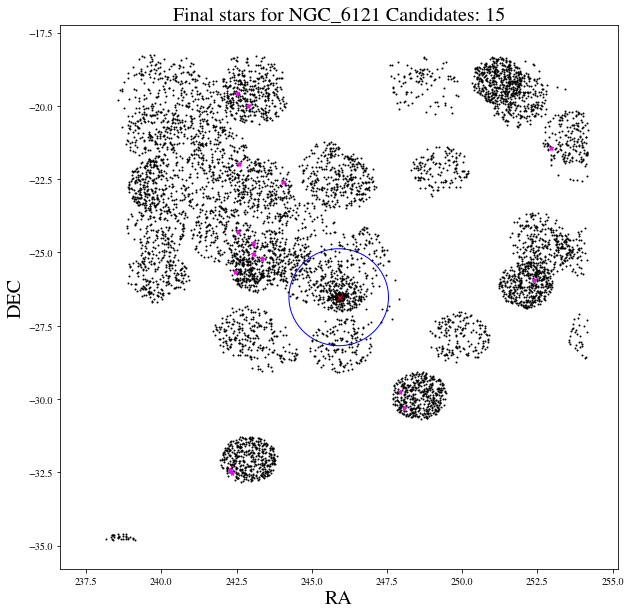

Final ET: 15


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


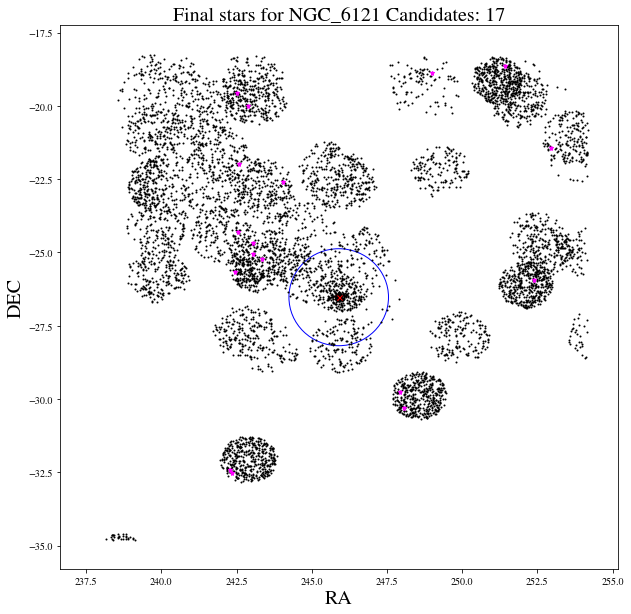

Final ET tSNE: 17


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


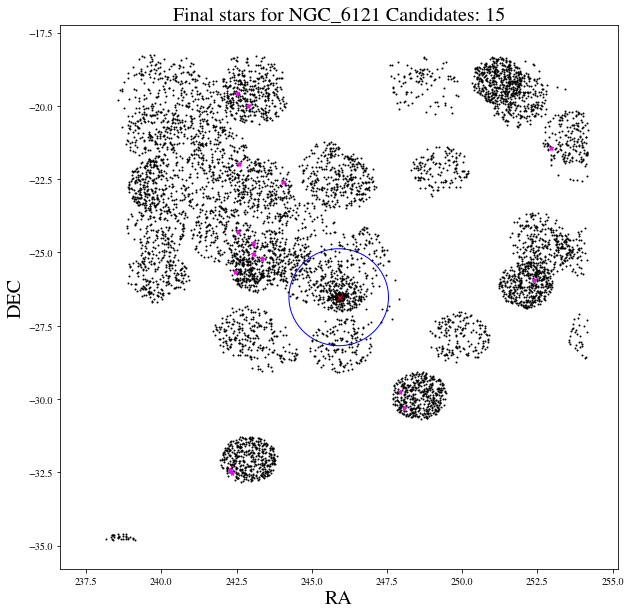

Final ET UMAP: 15

That shit took  5.308736479282379  mins


'play_obj.wait_done()\nplay_obj.stop()'

In [72]:
start = time.time()

for i in tqdm(range(12,13)):
    '''if GC_name_arr[i] == 'NGC_6121':
        print('fuck you')
        final_tsne.append([])
        final_umap.append([])
        final_et_arr.append([])'''
        
    #else:
    try:
        os.makedirs('GCs_20RHMRT_5RT/' + GC_name_arr[i])
    except OSError as error:
        print('\nDirectory ' + GC_name_arr[i] + ' already exists')

    tsne_pack = [tsne_control_X_nokin[i], tsne_control_Y_nokin[i], tsne_all_X_nokin[i], tsne_all_Y_nokin[i]]
    umap_pack = [umap_control_X_nokin[i], umap_control_Y_nokin[i], umap_all_X_nokin[i], umap_all_Y_nokin[i]]

    plot_ML_nokin(GC_name_arr[i], tsne_pack, 'tsne')
    #plot_ML_nokin(GC_name_arr[i], umap_pack, 'umap')


    tsne_eps_all, tsne_samp_all = db(GC_name_arr[i], 'tsne', tsne_all_X_nokin[i], tsne_all_Y_nokin[i], tsne_ctrl_inds[i])
    umap_eps_all, umap_samp_all = db(GC_name_arr[i], 'umap', umap_all_X_nokin[i], umap_all_Y_nokin[i], umap_ctrl_inds[i])


    tsne_et = db_opt(GC_name_arr[i], 'tsne', tsne_all_X_nokin[i], tsne_all_Y_nokin[i], tsne_eps_all, tsne_samp_all, tsne_ctrl_inds[i])
    umap_et = db_opt(GC_name_arr[i], 'umap', umap_all_X_nokin[i], umap_all_Y_nokin[i], umap_eps_all, umap_samp_all, umap_ctrl_inds[i])

    temp_var = final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], tsne_et, umap_et)[0]

    #final_tsne.append(final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], tsne_et, umap_et)[1])
    #final_umap.append(final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], tsne_et, umap_et)[2])
    
    final_tsne = final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], tsne_et, umap_et)[1]
    final_umap = final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], tsne_et, umap_et)[2]

    
    ### table making
    print('Number of tSNE stars: ' + str(len(tsne_et)))
    print('Number of UMAP stars: ' + str(len(umap_et)))

    if len(temp_var) == 0:
        #print('Nothing to plot, you got no controls yo\n')
        final_et_arr.append([])
    else:
        #final_et_arr.append(plot_shit_and_rt_filter(GC_name_arr[i], i, temp_var))
        final_et_arr = plot_shit_and_rt_filter(GC_name_arr[i], i, temp_var)
        print('Final ET: ' + str(len(final_et_arr)))
        print('Final ET tSNE: ' + str(len(plot_shit_and_rt_filter(GC_name_arr[i], i, final_tsne))))
        print('Final ET UMAP: ' + str(len(plot_shit_and_rt_filter(GC_name_arr[i], i, final_umap))))
        #print('\n')
    
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

'''wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()'''
'''play_obj.wait_done()
play_obj.stop()'''

In [84]:
play_obj.stop()

In [79]:
with open('saved_runs_5_RT/final_et_stars.pkl', 'wb') as f:
    pickle.dump(final_et_arr, f)
    
with open('saved_runs_5_RT/final_tsne_et_stars.pkl', 'wb') as f:
    pickle.dump(final_tsne, f)
    
with open('saved_runs_5_RT/final_umap_et_stars.pkl', 'wb') as f:
    pickle.dump(final_umap, f)

In [74]:
with open('saved_runs_5_RT/final_et_stars.pkl', 'rb') as f:
    final_et_arr = pickle.load(f)
    
with open('saved_runs_5_RT/final_tsne_et_stars.pkl', 'rb') as f:
    final_tsne = pickle.load(f)
    
with open('saved_runs_5_RT/final_umap_et_stars.pkl', 'rb') as f:
    final_umap = pickle.load(f)